In [1]:
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import HistGradientBoostingClassifier
import plotly.express as px

In [28]:
mup =pd.read_feather("muplus.feather") #read in mu plus feather file to pandas dataframe
print(f"Number of muplus events in data set is {len(mup)}")

ele = pd.read_feather("electrons_large.feather") #read in electron feather to pandas
print(f"Number of electron events in data set is {len(ele)}")

mum = pd.read_feather("muminus.feather") #read in mu minus file
print(f"Number of muminus events in data set is {len(mum)}")

pos = pd.read_feather("positrons.feather") #read in positron file
print(f"Number of positron events in data set is {len(pos)}")

Number of muplus events in data set is 456616
Number of electron events in data set is 303723
Number of muminus events in data set is 468196
Number of positron events in data set is 35551


In [29]:
#create filtered dataframes containing only e-/+ and mu-/+. 

ele_filt = ele.loc[ele['pdg_id']==11]
pos1_filt = ele.loc[ele['pdg_id']==-11] 
mup_filt = mup.loc[mup['pdg_id']==-13]
pos2_filt = pos.loc[pos['pdg_id']==-11]
mum_filt = mum.loc[mum['pdg_id']==13]
pos_filt = pd.concat([pos1_filt, pos2_filt], ignore_index=True) #not man positron events in the file i had on disk, so add e+ events from the e- files.

In [30]:
print(ele_filt.shape,mup_filt.shape,pos_filt.shape,mum_filt.shape) #check to see dimensons of dataframes

(185244, 11) (394187, 11) (40333, 11) (390814, 11)


In [5]:
#combine the four dfs into one
combined_df = pd.concat([ele_filt, pos_filt, mup_filt, mum_filt], ignore_index=True)

#shuffle the combined df to randomize the entries
shuffled_df= combined_df.sample(frac = 1)
print(f"Number of shuffled events: {len(shuffled_df)}")

Number of shuffled events: 1010578


In [6]:
shuffled_df.head() #looking good

,energy,energy_cor,x,y,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy,pdg_id
194928,0.883884,1.149860,-222.432953,-28.435123,-231.431488,-26.343822,3,0.747653,-20,-1,-11
814044,0.192199,0.285920,-68.171143,-42.072369,-57.716438,-40.204338,2,0.156949,-9,-2,13
236078,0.210711,0.289468,103.603897,29.301708,91.495529,39.352322,1,0.210711,5,1,-13
454713,0.241966,0.310830,-25.104607,-42.060368,-37.405815,-48.973721,2,0.124543,-6,-2,-13
764674,0.272500,0.341468,-177.779221,39.023926,-170.356384,37.914646,3,0.125480,-16,2,13


In [31]:
#split shuffled dataframe into two: one for training, one for validation.

shuffled_training_df = shuffled_df.iloc[0:750000]
shuffled_validation_df = shuffled_df.iloc[750000:]
print(f"Number of total shuffled events for training: {len(shuffled_training_df)}")
print(f"Number of shuffled events for validation: {len(shuffled_validation_df)}")

Number of total shuffled events for training: 750000
Number of shuffled events for validation: 260578


In [8]:
for col in shuffled_training_df.columns:
    print(col)

energy
energy_cor
x
y
x_cor
y_cor
nhits
seed_e
seed_ix
seed_iy
pdg_id


In [62]:
#drop the redundant or truth features
#we drop the uncorrected features because the corrected features give better results later on.

train_df = shuffled_training_df.drop(columns=['x','y','energy']) 
val_df = shuffled_validation_df.drop(columns=['x','y','energy'])


In [63]:
#prepare four dataframes for sklearn's BD Tree:

X_train = train_df.drop(columns=['pdg_id']) #remove the 'truth' aka pdg_id column from the features dataset
X_test = val_df.drop(columns=['pdg_id']) #same thing, but for the df for testing the model
Y_train = train_df['pdg_id'] #this is the df containing the truth values for the X_train features, aka which particle they are
Y_test = val_df['pdg_id'] #contains truth values for the test set 

In [64]:
X_train.shape[0]==Y_train.shape[0] #sanity check

clf = tree.DecisionTreeClassifier() #create training function

In [65]:
%%time
#train!
clf.fit(X_train, Y_train)

CPU times: user 10 s, sys: 9.47 ms, total: 10.1 s
Wall time: 10.1 s


DecisionTreeClassifier()

In [90]:
clf_pred = clf.predict(X_test)

In [91]:
print("Training set score (should be very close to 1): %f" % clf.score(X_train, Y_train))
print("Test set score (how accurate the model is at classifying mu+/e-/mu-/e+): %f" % clf.score(X_test, Y_test))
print(f"So using {X_test.shape[0]} datapoints, we on average have a {(1-clf.score(X_test,Y_test))*100} % error at classifying 4 different kinds of particles")
clf_score = clf.score(X_test,Y_test)

Training set score (should be very close to 1): 0.999201
Test set score (how accurate the model is at classifying mu+/e-/mu-/e+): 0.831417
So using 260578 datapoints, we on average have a 16.85829195097054 % error at classifying 4 different kinds of particles


<BarContainer object of 7 artists>

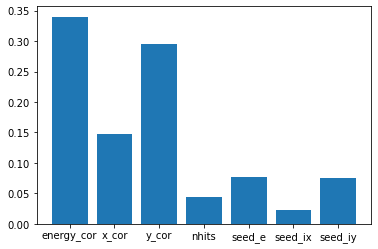

In [92]:
plt.bar(clf.feature_names_in_,clf.feature_importances_)

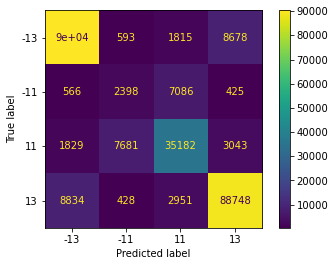

In [110]:
#create and plot the confusion matrix for the normal decision tree
clf_cmatrix = sklearn.metrics.confusion_matrix(Y_test, clf_pred, labels=clf.classes_)
display = sklearn.metrics.ConfusionMatrixDisplay(clf_cmatrix, display_labels=clf.classes_)
display.plot()
plt.show()

In [69]:
%%time
hist_gradient_BC = HistGradientBoostingClassifier().fit(X_train,Y_train)

CPU times: user 1min 53s, sys: 637 ms, total: 1min 54s
Wall time: 15 s


In [111]:
hist_score = hist_gradient_BC.score(X_test,Y_test)
hist_pred = hist_gradient_BC.predict(X_test)
print(f"decision tree score: {clf_score}, hist gradient score: {hist_score}")
print(f"Hist gradient is: {100*(hist_score - clf_score)}) better than the basic decision tree")

decision tree score: 0.8314170804902946, hist gradient score: 0.8845412889806507
Hist gradient is: 5.312420849035604) better than the basic decision tree


In [72]:
feature_fig = px.bar(x = clf.feature_names_in_ ,y= clf.feature_importances_,labels=dict(x="Feature", y='Importance'), title = 'Feature Importances in Classification of e-/+,mu-/+. N_training =750,000 ')
feature_fig.show()

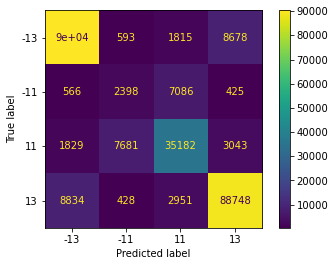

In [114]:
#create and plot the confusion matrix for the hist gradient boosted decision classifier 
hist_cmatrix = sklearn.metrics.confusion_matrix(Y_test, hist_pred,labels=clf.classes_)
hist_display = sklearn.metrics.ConfusionMatrixDisplay(hist_cmatrix, display_labels=hist_gradient_BC.classes_)
display.plot()
plt.show()